In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from lbow.twoDimensional.steadystate import HalfPlaneModel

# Analytical solution of the flow over a bell-shaped mountain with circular contours

This notebook shows how to calculate the semi-analytical solution of the uniform, stratified flow over a two-dimensional bell-shaped hill with circular contours. The semi-analytical solution is obtained with LBoW, which solves linear theory of buoyancy waves.

Copyright 2022 Dries Allaerts

Licensed under the Apache License, Version 2.0.

## Set-up

### Input parameters

Flow parameters: wind speed U and Brunt Vaisala frequency N

In [109]:
U = 10   # Wind speed x-component [m/s]
V = 0   # Wind speed x-component [m/s]
N = 0.1 # Brunt-Vaisala frequency [1/s]

Hill shape $h\left(x,y\right) = \large\frac{h_{max}}{\left(\frac{x^2+y^2}{L^2}+1\right)^{3/2}}$


In [126]:
L = 1000.0   # Characteristic width of the hill [m]
hmax = 10.0 # Height of the hill [m]

# Shape function of the hill
h = lambda x,y: hmax/((x**2+y**2)/L**2+1)**(3/2)

Numerical parameters

In [175]:
Lx = 400.0e3 # Length of the numerical domain [m]
Nx = int(4e3) # Number of grid points

In [176]:
Ly = 100.0e3 # Length of the numerical domain [m]
Ny = int(1e3) # Number of grid points

Parameters for visualization

In [177]:
Lz = 1.0e3 # Height up to which solution is calculated [m]
Nz = 51    # Number of vertical levels to be used

### Numerical grid

In [178]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dx))

Horizontal grid resolution is 100.0 m


In [179]:
ys,dy = np.linspace(-Ly/2,Ly/2,Ny,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dy))

Horizontal grid resolution is 100.0 m


In [180]:
zs,dz = np.linspace(0,Lz,Nz,retstep=True)
print('Vertical resolution is {} m'.format(dz))

Vertical resolution is 20.0 m


In [181]:
Xs,Ys = np.meshgrid(xs,ys,indexing='ij')

### Model

In [182]:
model = HalfPlaneModel(Xs,Ys,h(Xs,Ys),U,V,N)

### Visualize hill

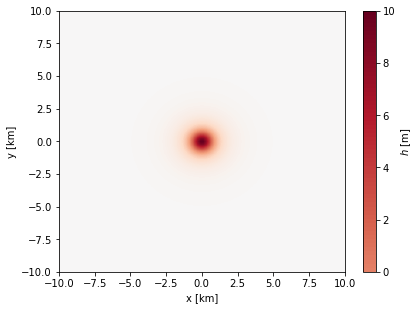

In [183]:
f,ax=plt.subplots(1,1,figsize=(6.4,4.8))

# Plot displacement in left axis
im=ax.imshow(h(Xs,Ys).T,
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, ys[0]/1e3, ys[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.)
            )
cbar = f.colorbar(im,ax=ax,shrink=1.0,label=r'$h$ [m]')
_ = ax.set(xlim=[-10,10],ylim=[-10,10],xlabel='x [km]',ylabel='y [km]')

## Solve flow problem

In [184]:
%time eta = model.solve('eta',zs)

CPU times: user 11 s, sys: 6.23 s, total: 17.2 s
Wall time: 15.2 s


In [185]:
%time w = model.solve('w',zs)

CPU times: user 11.4 s, sys: 6.21 s, total: 17.6 s
Wall time: 13.7 s


## Visualization

### Contourplots of vertical displacement $\eta$ and vertical velocity $w$ at $y=0$

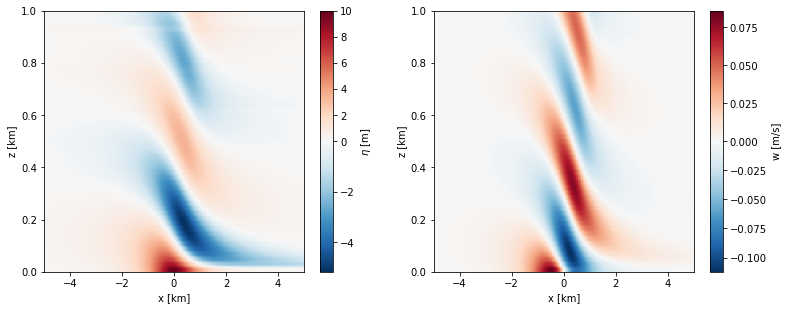

In [186]:
f,ax=plt.subplots(1,2,figsize=(12.8,4.8))

# Plot displacement in left axis
im=ax[0].imshow(np.squeeze(eta[...,int(Ny/2)]),
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.))
cbar = f.colorbar(im,ax=ax[0],shrink=1.0,label=r'$\eta$ [m]')
_ = ax[0].set(xlim=[-5,5],ylim=[0,1],xlabel='x [km]',ylabel='z [km]')

# Plot vertical velocity in right axis
im=ax[1].imshow(np.squeeze(w[...,int(Ny/2)]),
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.))

# figure mark-up
cbar = f.colorbar(im,ax=ax[1],shrink=1.0,label='w [m/s]')
_ = ax[1].set(xlim=[-5,5],ylim=[0,1],xlabel='x [km]',ylabel='z [km]')

### Planform view of vertical displacement at various levels

This plot reproduces figure 1 from [Smith (1980)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.2153-3490.1980.tb00962.x)

In [196]:
zs_Smith = np.array([0.125,0.25,0.5,1])*np.pi*U/N
eta_Smith = model.solve('eta',zs_Smith)

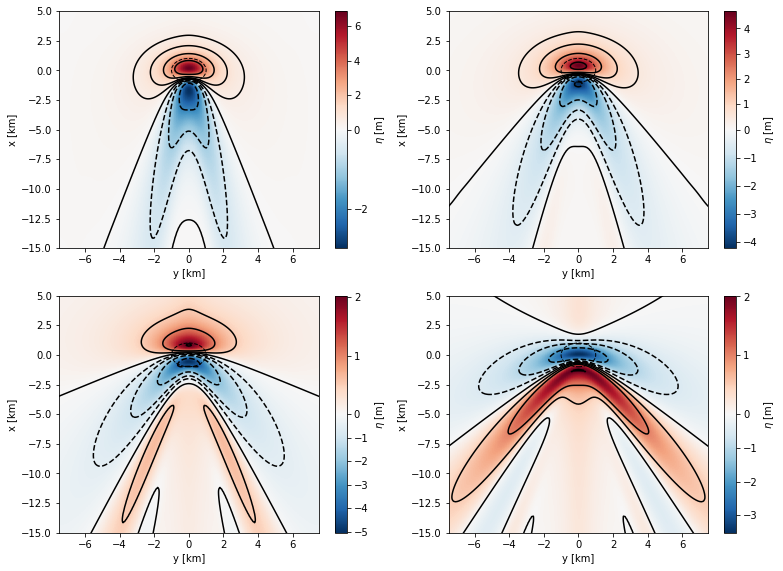

In [199]:
f,ax=plt.subplots(2,2,figsize=(12.8,9.6))

for idx in range(4):
    axs=ax.ravel()
    #Colour plot
    im=axs[idx].imshow(np.flipud(eta_Smith[idx,...]),
                 origin='lower',
                 extent=[ys[0]/1e3, ys[-1]/1e3, xs[0]/1e3, xs[-1]/1e3],
                 aspect='auto',
                 cmap='RdBu_r',
                 norm=TwoSlopeNorm(vcenter=0.))
    cbar = f.colorbar(im,ax=axs[idx],shrink=1.0,label=r'$\eta$ [m]')
    #Contour
    cs = axs[idx].contour(Ys/1e3,Xs/1e3,np.flipud(eta_Smith[idx,...]),[-4,-2,-1,-0.5,0,0.5,1,2,4],colors='k')
    #axs[idx].clabel(cs, fontsize=9, inline=True)
    # Circle at the origin witrh radius L
    circle = plt.Circle((0, 0), L/1e3, color='k',linestyle='--',fill=False)
    axs[idx].add_patch(circle)
    #Axes mark up
    _ = axs[idx].set(xlim=[-7.5,7.5],ylim=[-15,5],xlabel='y [km]',ylabel='x [km]')